In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import numpy
import xml.etree.ElementTree as ET
from glob import glob
import datetime
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Liulin

In [57]:
filename = './data/HIMAC/liulin/1801202205.y14'

# extract time
path = filename.split('/')
time = path[-1].split('.')
print time
date_object = datetime.datetime.strptime(time[0], '%y%m%d%H%M')
print date_object

# read data
liulin = pd.read_csv(filename, header = None, sep = ' ', skiprows = 1) # read Liulin data Y
liulin = liulin.drop(256, axis=1) # delete last empty column
infile = open(filename, 'r')
header = infile.readline()
print header # print data header
exposition = header.split(' ')[4].split('[')[0] # extract exposition time  
exposition_val = float(exposition)
exposition += 'S'
print exposition

# compute time series
#dates = pd.date_range(date_object, freq='5T', periods=len(liulin)).tolist()


['1801202205', 'y14']
2018-01-20 22:05:00
MDU-14  EXPOSITION = 60[sec]

60S


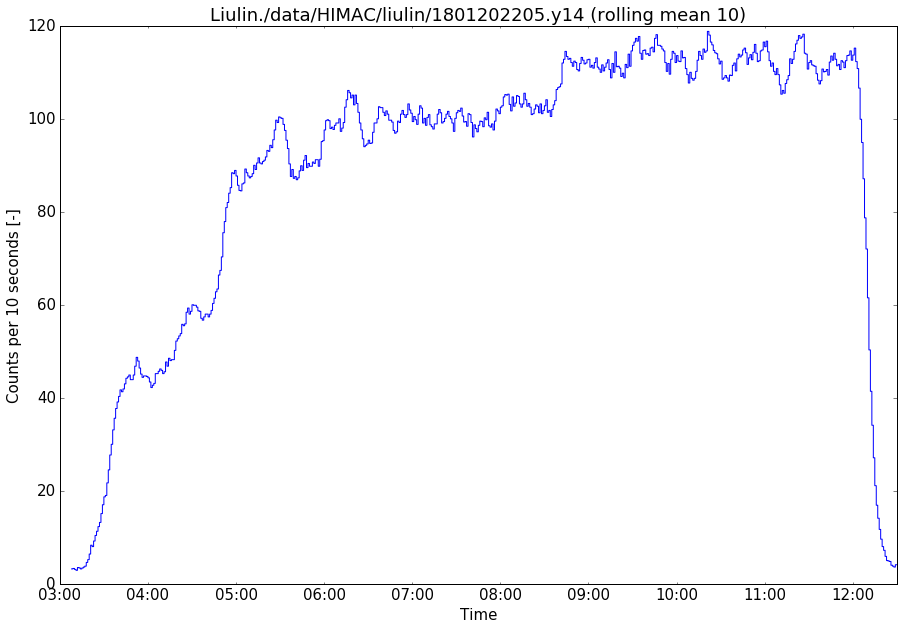

In [58]:
#liulin_data = pd.DataFrame(index = pd.date_range(date_object, freq='5T', periods=len(liulin)).tolist(), data = liulin.as_matrix())
# index liulin data (compute time)
liulin_data = pd.DataFrame(index = pd.date_range(date_object, freq=exposition, periods=len(liulin)).tolist(), data = liulin.as_matrix())
liulin_data['flux'] = liulin_data[range(0,256)].sum(axis=1)
#liulin_data = liulin_data.loc['2018-08-02 17:00:00':'2018-08-03 13:00:00']
#ABSjets liulin_data = liulin_data.loc['2017-11-29 12:00:00':'2017-11-29 15:30:00']
liulin_data = liulin_data.loc['2018-01-21 03:00:00':'2018-01-21 12:30:00']

WINDOW = 10
liulin_data['flux'] = pd.rolling_mean(liulin_data['flux'],WINDOW)
liulin_data['flux'] = liulin_data['flux'] 

#liulin_data
plt.figure(figsize=(15, 10))
matplotlib.rcParams.update({'font.size': 15})
liulin_data['flux'].plot(drawstyle='steps')
plt.title('Liulin' + filename + ' (rolling mean ' + str(WINDOW) + ')')
plt.ylabel('Counts per 10 seconds [-]')
plt.xlabel('Time')
#plt.ylim(0, 20)


## AIRDOS

In [59]:
fto = './data/HIMAC/AIRDOS_T4/DATALOG.TXT' #  File to Open
l=[]
l.extend(range(0,520))
df = pd.read_table(fto, sep=',', header=None, names=l, comment='*',engine='python')

#
''' DEBUG
df = df.reset_index(drop=True)
df.drop(df[df.index > 100].index, inplace=True)
'''#'''

df.drop(df[df[0]=='$GPTXT'].index, inplace=True)
#df.drop(r[r[0]=='$GPRMC'].index, inplace=True)
df.drop(df[df[0]=='$GPVTG'].index, inplace=True)
df.drop(df[df[0]=='$GPGLL'].index, inplace=True)
df.drop(df[df[0]=='$GPGSA'].index, inplace=True)
df.drop(df[df[0]=='$GPGSV'].index, inplace=True)
#df.drop(df[df[0]=='$CANDY'].index, inplace=True)

# Convert strings to numbers
#df = df.apply(pd.to_numeric, errors='ignore')

#df.iloc[:,0:13]

#df

In [60]:
date = np.nan #pd.to_datetime('210317000000.00', format='%d%m%y%H%M%S.%f')
altitude = np.nan
LatDD = np.nan
LonDD = np.nan
speed = np.nan
flag=0

for i,r in df.iterrows():
    if (r[0] == '$GPRMC'):
        date = pd.to_datetime(str(r[9])+str(r[1]), format='%d%m%y%H%M%S.%f',errors='coerce')
        flag = 1
        speed = r[7]
        
    if (r[0] == '$GPGGA'):
        altitude = r[9]

    df.set_value(i,'date',date)
    #df.set_value(i,'altitude',np.nan)
    df.set_value(i,'altitude',altitude)
    df.set_value(i,'speed',speed)

    if (r[0] == '$CANDY'):
        date = date + pd.Timedelta(seconds=14)
        df.set_value(i,'date',date)
        #if (flag==1):
        #    df.set_value(i,'altitude',altitude)
        #    flag=0
        
dfo = df
#dfo.reset_index(inplace=True)
dfo.drop(dfo[dfo[0]=='$GPRMC'].index, inplace=True)
dfo.drop(dfo[dfo[0]=='$GPGGA'].index, inplace=True)

dfo.to_csv('radiation.csv')

## Liulin & AIRDOS flux

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



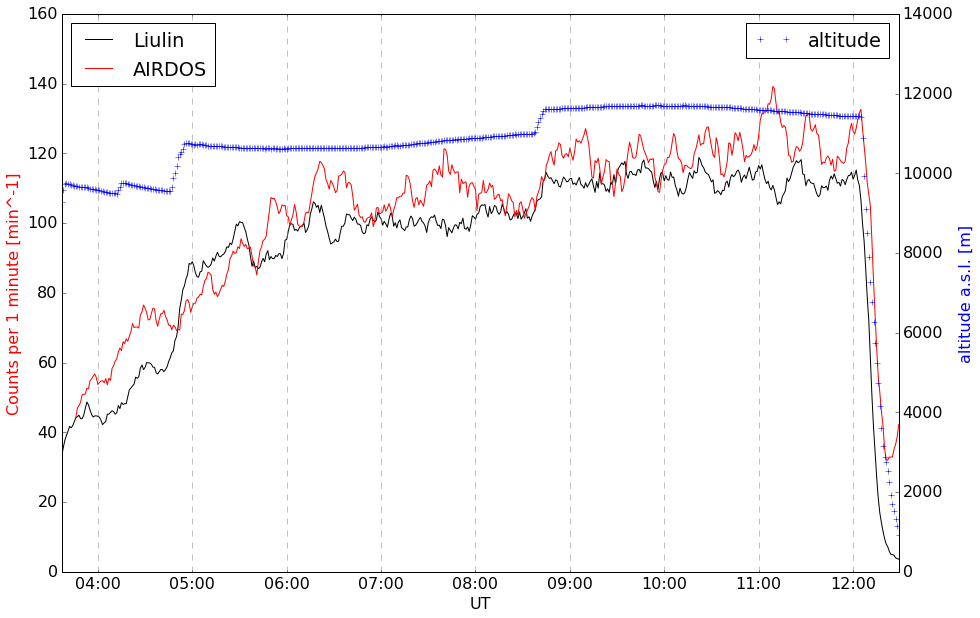

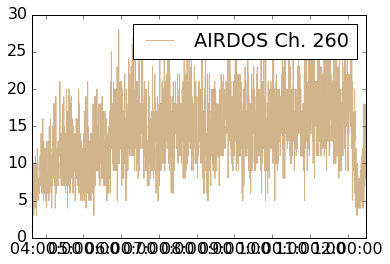

In [31]:
#DeviceName = 'AIRDOS A005'
DeviceName = 'AIRDOS T4'

dfo = pd.read_table('radiation.csv', sep=',', header=0)
#dfo = dfo.dropna(how='any')
dfo = dfo.dropna(subset=['date'])
dfo['date'] = pd.to_datetime(dfo['date'])
dfo = dfo.set_index(['date'])
#xx = dfo.loc['2018-01-03 17:00:00':]
#xx = dfo.loc['2018-06-23 11:00:00':'2018-06-27 10:00:00']
#ABSjets xx = dfo.loc['2017-11-29 12:30:00':'2017-11-29 16:00:00']
xx = dfo.loc['2018-01-21 02:00:00':'2018-01-21 12:30:00']
#xx = dfo

xxl = liulin_data

NOISE_LEVEL=260
LAST_CHANNEL=515
xx['flux'] = xx[range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1)
liulin_data['flux'] = liulin_data[range(0,256)].sum(axis=1)

xxs = xx.resample('1 min', how='sum')
xxm = xx.resample('1 min', how='mean')

#pandas.rolling_mean(arg, window, min_periods=None, freq=None, center=False, how=None, **kwargs)
WINDOW = 10
xxs['flux'] = pd.rolling_mean(xxs['flux'],WINDOW)
xxl['flux'] = pd.rolling_mean(liulin_data['flux'],WINDOW)

plt.figure(figsize=(15,10))
matplotlib.rcParams.update({'font.size': 16})

xxl['flux'].plot(c='black', label = 'Liulin') # drawstyle='steps', 
xxs['flux'].plot(c='red', label = 'AIRDOS')
#plt.plot(xx.iloc[:,NOISE_LEVEL],c='tan',label='AIRDOS 1. Ch.',zorder=1)

plt.ylim([0,160])

plt.xlabel('UT')
plt.ylabel('Counts per 1 minute [min^-1]', color='red')
plt.legend(loc=2)

plt.grid(b=True, which='major', color='grey', linestyle='')
plt.grid(b=True, which='minor', color='grey', linestyle='--')

ax = plt.twinx()

plt.ylim([0,14000])
xxm['altitude'].plot(c='b', marker='+', linewidth='2', linestyle='none', label='altitude')
#xx['altitude'].plot(c='b', label='alt', linewidth='1')
plt.ylabel('altitude a.s.l. [m]', color='b')

plt.grid(b=True, which='major', color='grey', linestyle='')
plt.grid(b=True, which='minor', color='grey', linestyle='')
plt.legend()
#plt.title('Aircraft (rolling mean ' + str(WINDOW) + ')')

plt.savefig("aircraft.pdf", format="pdf")

#
'''flux to file
xxx = pd.DataFrame()
xxx = xx[['altitude','flux','speed']]
xxx.to_csv('flux.csv')
#'''

plt.figure()
#matplotlib.rcParams.update({'font.size': 10})
plt.plot(xx.iloc[:,NOISE_LEVEL],c='tan',label='AIRDOS Ch. '+str(NOISE_LEVEL),zorder=1)
plt.legend()


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



"flux to file\nxxx = pd.DataFrame()\nxxx = xx[['altitude','flux','speed']]\nxxx.to_csv('flux.csv')\n#"

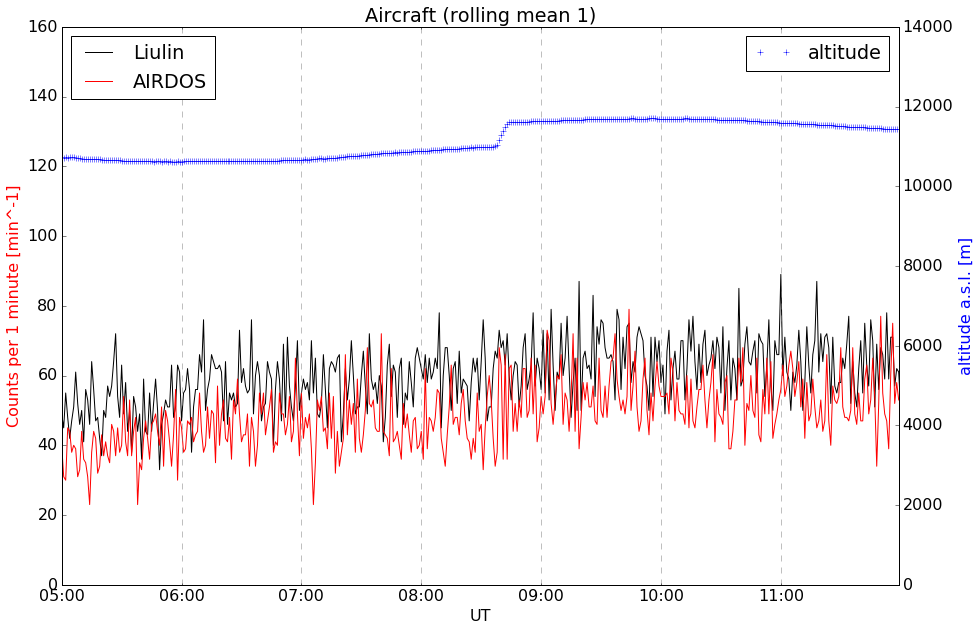

In [65]:
#DeviceName = 'AIRDOS A005'
DeviceName = 'AIRDOS T4'
plt.figure(figsize=(15,10))
matplotlib.rcParams.update({'font.size': 16})

dfo = pd.read_table('radiation.csv', sep=',', header=0)
#dfo = dfo.dropna(how='any')
dfo = dfo.dropna(subset=['date'])
dfo['date'] = pd.to_datetime(dfo['date'])
dfo = dfo.set_index(['date'])
#xx = dfo.loc['2018-01-03 17:00:00':]
#xx = dfo.loc['2018-06-23 11:00:00':'2018-06-27 10:00:00']
#ABSjets xx = dfo.loc['2017-11-29 12:30:00':'2017-11-29 16:00:00']
#xx = dfo.loc['2018-01-21 02:00:00':'2018-01-21 12:30:00']
xx = dfo.loc['2018-01-21 05:00:00':'2018-01-21 12:00:00']
#xx = dfo

xxl = liulin_data

NOISE_LEVEL=261
LAST_CHANNEL=515
xx['flux'] = xx[range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1)
liulin_data['flux'] = liulin_data[range(3,256)].sum(axis=1)

xxs = xx.resample('1 min', how='sum')
xxm = xx.resample('1 min', how='mean')

#pandas.rolling_mean(arg, window, min_periods=None, freq=None, center=False, how=None, **kwargs)
WINDOW = 1
xxs['flux'] = pd.rolling_mean(xxs['flux'],WINDOW)
xxl['flux'] = pd.rolling_mean(liulin_data['flux'],WINDOW)

plt.figure(figsize=(15,10))
matplotlib.rcParams.update({'font.size': 16})

xxl['flux'].plot(c='black', label = 'Liulin') # drawstyle='steps', 
xxs['flux'].plot(c='red', label = 'AIRDOS')
#plt.plot(xx.iloc[:,NOISE_LEVEL],c='tan',label='AIRDOS 1. Ch.',zorder=1)

plt.ylim([0,160])

plt.xlabel('UT')
plt.ylabel('Counts per 1 minute [min^-1]', color='red')
plt.legend(loc=2)

plt.grid(b=True, which='major', color='grey', linestyle='')
plt.grid(b=True, which='minor', color='grey', linestyle='--')

ax = plt.twinx()

plt.ylim([0,14000])
xxm['altitude'].plot(c='b', marker='+', linewidth='2', linestyle='none', label='altitude')
#xx['altitude'].plot(c='b', label='alt', linewidth='1')
plt.ylabel('altitude a.s.l. [m]', color='b')

plt.grid(b=True, which='major', color='grey', linestyle='')
plt.grid(b=True, which='minor', color='grey', linestyle='')
plt.legend()
plt.title('Aircraft (rolling mean ' + str(WINDOW) + ')')

plt.savefig("aircraft2.svg", format="svg")

#
'''flux to file
xxx = pd.DataFrame()
xxx = xx[['altitude','flux','speed']]
xxx.to_csv('flux.csv')
#'''


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



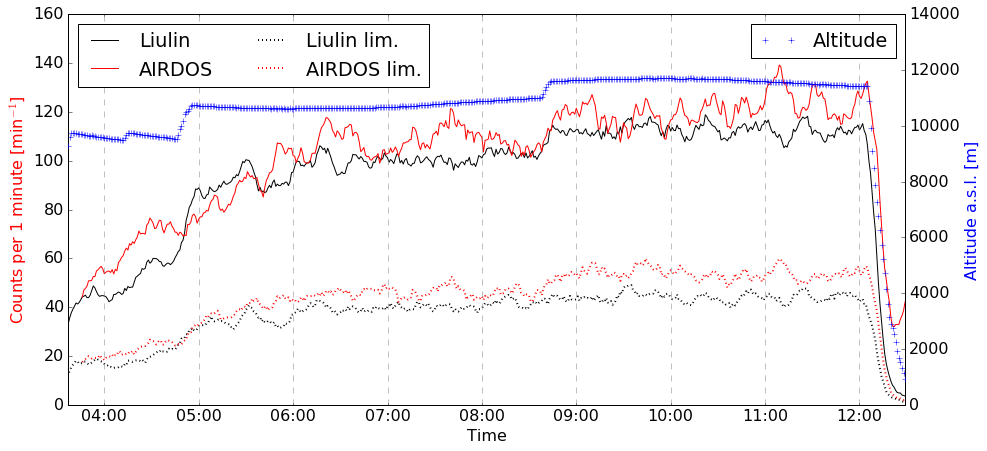

In [159]:
dfo = pd.read_table('radiation.csv', sep=',', header=0)
#dfo = dfo.dropna(how='any')
dfo = dfo.dropna(subset=['date'])
dfo['date'] = pd.to_datetime(dfo['date'])
dfo = dfo.set_index(['date'])
#xx = dfo.loc['2018-01-03 17:00:00':]
#xx = dfo.loc['2018-06-23 11:00:00':'2018-06-27 10:00:00']
#ABSjets xx = dfo.loc['2017-11-29 12:30:00':'2017-11-29 16:00:00']
xx = dfo.loc['2018-01-21 02:00:00':'2018-01-21 12:30:00']
#xx = dfo

xxl = liulin_data

#------------------------
NOISE_LEVEL=260
LAST_CHANNEL=515
xx['flux'] = xx[range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1)
liulin_data['flux'] = liulin_data[range(0,256)].sum(axis=1)

xxs = xx.resample('1 min', how='sum')
xxm = xx.resample('1 min', how='mean')

#pandas.rolling_mean(arg, window, min_periods=None, freq=None, center=False, how=None, **kwargs)
WINDOW = 10
xxs['flux'] = pd.rolling_mean(xxs['flux'],WINDOW)
xxl['flux'] = pd.rolling_mean(liulin_data['flux'],WINDOW)

plt.figure(figsize=(15,7))
matplotlib.rcParams.update({'font.size': 16})

xxl['flux'].plot(c='black', label = 'Liulin') # drawstyle='steps', 
xxs['flux'].plot(c='red', label = 'AIRDOS')

#------------------------
NOISE_LEVEL=261
LAST_CHANNEL=515
xx['flux'] = xx[range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1)
liulin_data['flux'] = liulin_data[range(4,256)].sum(axis=1)

xxs = xx.resample('1 min', how='sum')
xxm = xx.resample('1 min', how='mean')

#pandas.rolling_mean(arg, window, min_periods=None, freq=None, center=False, how=None, **kwargs)
WINDOW = 10
xxs['flux'] = pd.rolling_mean(xxs['flux'],WINDOW)
xxl['flux'] = pd.rolling_mean(liulin_data['flux'],WINDOW)

xxl['flux'].plot(c='black', lw=2, linestyle=':', label = 'Liulin lim.') # drawstyle='steps', 
xxs['flux'].plot(c='red', lw=2, linestyle=':', label = 'AIRDOS lim.')

plt.ylim([0,160])

plt.xlabel('Time')
plt.ylabel(r'Counts per 1 minute [min$^{-1}$]', color='red')
#plt.legend(loc=2, framealpha=1)
plt.legend(loc="upper left", bbox_to_anchor=[0, 1], ncol=2)

plt.grid(b=True, which='major', color='grey', linestyle='')
plt.grid(b=True, which='minor', color='grey', linestyle='--')

ax = plt.twinx()

plt.ylim([0,14000])
xxm['altitude'].plot(c='b', marker='+', linewidth='2', linestyle='none', label='Altitude',zorder=99)
#xx['altitude'].plot(c='b', label='alt', linewidth='1')
plt.ylabel('Altitude a.s.l. [m]', color='b')

plt.grid(b=True, which='major', color='grey', linestyle='')
plt.grid(b=True, which='minor', color='grey', linestyle='')
plt.legend(framealpha=1)
#plt.title('Aircraft (rolling mean ' + str(WINDOW) + ')')

plt.savefig("aircraft.pdf", format="pdf", bbox_inches='tight')



## Spectra

In [190]:
import plotly.plotly as py
import plotly.graph_objs as go

LOW_ENERGY = 0

e1 = ['2018-01-21 05:00:00','2018-01-21 12:00:00']

ener1 = liulin_data.ix[e1[0]:e1[1],LOW_ENERGY:256].sum()

print ener1[2:].sum()

e = pd.DataFrame()
e['1'] = ener1
e['index'] = ener1.index
#e['x'] =  linspace(0.0407, 20.7977, 256)
e['x'] =  linspace(0.0814/2, 20.7977, 256)


data = [
    go.Scatter(
        x=e['x'],
        y=e['1'],
        name='aircraft',
        yaxis='y',
        line=dict(
        shape='hvh'
        )
    ),    
    ]
        
layout = go.Layout(
    title='Liulin',
    yaxis=dict(
        title='counts',
        type='log',
        #range = [0,20000]
    ),
    xaxis=dict(
        title='ε [MeV]',
    ),
)

e.to_csv('./data/liulin.csv')

e['x'] =  linspace(0.0692/2, 17.7, 256)

e.to_csv('./data/liulin2.csv')

#fig = go.Figure(data=data, layout=layout)
#py.iplot(fig, filename='ble')


41399


In [191]:
import plotly.plotly as py
import plotly.graph_objs as go

ee = pd.read_table('./data/liulin.csv', sep=',', header=0,engine='python' )
eee = pd.read_table('./data/liulin2.csv', sep=',', header=0,engine='python' )

# Solving following system of linear equations
# 237a + b = 6.12
# 215a + b = 5.49
tl = 0.5
#l = np.array([[41, 1],[62,1]])
#r = np.array([1.02, 1.41])
#AIRDOS T4
l = np.array([[275, 1],[364,1]])
r = np.array([1, 5.4])
#A2
#l = np.array([[393, 1],[505,1]])
#r = np.array([2.45, 4.39])

coef = np.linalg.solve(l,r)
print coef[0], coef[1]


e1 = ['2018-01-21 05:00:00','2018-01-21 12:00:00']

ener1 = dfo.ix[e1[0]:e1[1],259:515].sum()

e = pd.DataFrame()
e['1'] = ener1
e['index'] = pd.to_numeric(ener1.index)
e['x'] = (e['index']) * coef[0] + coef[1]

data = [
    go.Scatter(
        x=e['x'],
        y=e['1'],
        name='AIRDOS<br>49.4 keV/Ch.',
        #yaxis='y',
        line=dict(
        shape='hvh'
        )
    ),    
    go.Scatter(
        x=ee['x'],
        y=ee['1'],
        name='Liulin<br>81.4 keV/Ch.',
        #yaxis='y',
        line=dict(
        shape='hvh'
        )
    ),    
    go.Scatter(
        x=eee['x'],
        y=eee['1'],
        name='Liulin<br>69.2 keV/Ch.',
        #yaxis='y',
        line=dict(
        shape='hvh'
        )
    ),    
    ]
        
layout = go.Layout(
    title='Aircraft',
    font=dict(family='Courier New, monospace', size=18, color='#7f7f7f'),
    yaxis=dict(
        title='counts',
        type='log',
        #range = [0,100]
    ),
    xaxis=dict(
        title='ε [MeV]',
    ),
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='ble')

0.0494382022472 -12.595505618


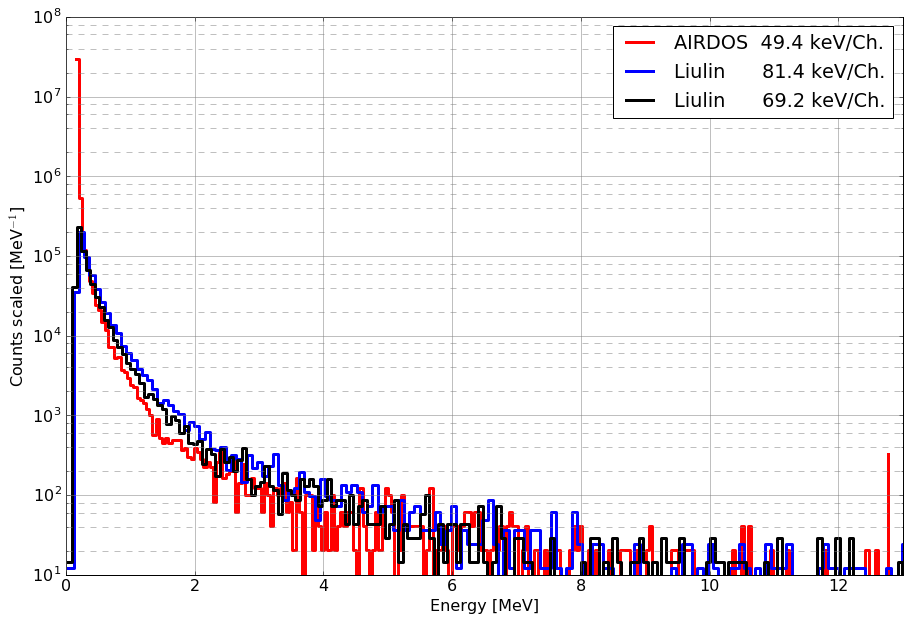

In [192]:
matplotlib.rcParams.update({'font.size': 16})

#from matplotlib import rc
#rc('text', usetex=False)

plt.figure(figsize=(15,10))

e['norm'] = e['1']/0.0494 #/0.0494
ee['norm'] = ee['1']/0.0814 #/0.0692 #/(0.0814/0.0494)
eee['norm'] = eee['1']/0.0692 #/0.0692 #/(0.0814/0.0494)

plt.plot(e['x'],e['norm'], c='r', lw=3, drawstyle='steps-post', label='AIRDOS  49.4 keV/Ch.')
#plt.plot(ee['x'],ee['norm'], c='grey', linestyle=':', lw=3, drawstyle='steps-post', label='Liulin      81.4 keV/Ch.')
plt.plot(ee['x'],ee['norm'], c='b', lw=3, drawstyle='steps-post', label='Liulin      81.4 keV/Ch.')
plt.plot(eee['x'],eee['norm'], c='black', lw=3, drawstyle='steps-post', label='Liulin      69.2 keV/Ch.')

#plt.ylim(1, 10e6)
plt.xlim(0, 13)
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Energy [MeV]')
plt.ylabel(r'Counts scaled [MeV$^{-1}$]')
plt.legend()
#plt.title('Aircraft')
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='--')

plt.savefig("aircraft_spectra.pdf", format="pdf", bbox_inches='tight')
ee.to_csv('./data/liulin_spectrum.csv')
e.to_csv('./data/airdos_spectrum.csv')


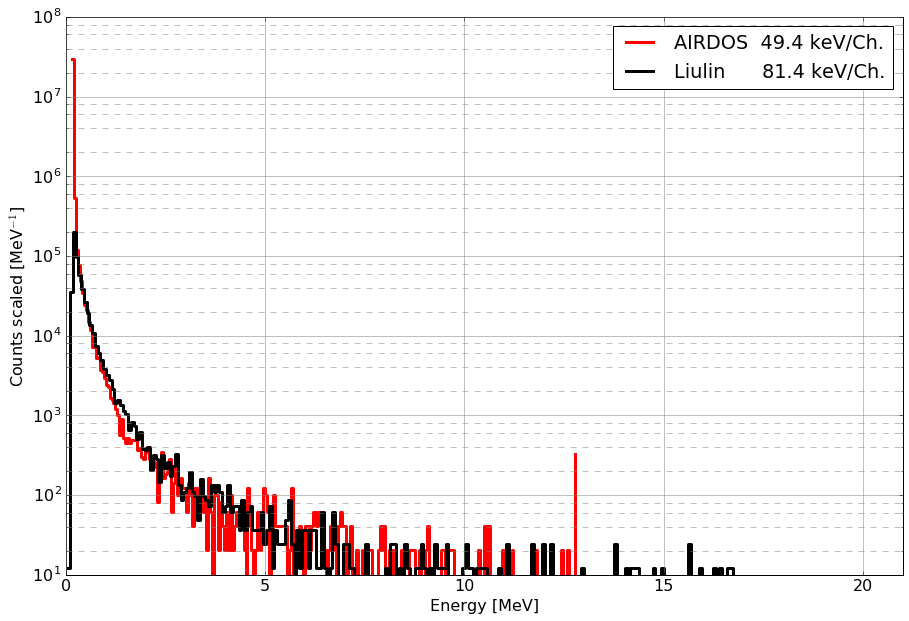

In [177]:
matplotlib.rcParams.update({'font.size': 16})

#from matplotlib import rc
#rc('text', usetex=False)

plt.figure(figsize=(15,10))

e['norm'] = e['1']/0.0494 #/0.0494
ee['norm'] = ee['1']/0.0814 #/0.0692 #/(0.0814/0.0494)
eee['norm'] = eee['1']/0.0692 #/0.0692 #/(0.0814/0.0494)

plt.plot(e['x'],e['norm'], c='r', lw=3, drawstyle='steps-post', label='AIRDOS  49.4 keV/Ch.')
#plt.plot(ee['x'],ee['norm'], c='grey', linestyle=':', lw=3, drawstyle='steps-post', label='Liulin      81.4 keV/Ch.')
plt.plot(ee['x'],ee['norm'], c='black', lw=3, drawstyle='steps-post', label='Liulin      81.4 keV/Ch.')
#plt.plot(eee['x'],eee['norm'], c='black', lw=3, drawstyle='steps-post', label='Liulin      69.2 keV/Ch.')

#plt.ylim(1, 10e6)
plt.xlim(0, 21)
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Energy [MeV]')
plt.ylabel(r'Counts scaled [MeV$^{-1}$]')
plt.legend()
#plt.title('Aircraft')
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='--')

plt.savefig("aircraft_spectra.pdf", format="pdf", bbox_inches='tight')
ee.to_csv('./data/liulin_spectrum.csv')
e.to_csv('./data/airdos_spectrum.csv')


In [206]:
from_energy = 0.25
to_energy = 12.7
#e.loc[e['x']>=from_energy]
#ee.loc[ee['x']>=from_energy]
e['dose']=e['1']*e['x']
ee['dose']=ee['1']*ee['x']
eee['dose']=eee['1']*eee['x']

liulin_particles = ee.loc[(ee['x']>=from_energy)]['1'].sum()
liulin_particles2 = eee.loc[(eee['x']>=from_energy)]['1'].sum()
airdos_particles = e.loc[(e['x']>=from_energy)]['1'].sum()

liulin_dose = ee.loc[(ee['x']>=from_energy)&(ee['x']<=to_energy)]['dose'].sum()
liulin_dose2 = eee.loc[(eee['x']>=from_energy)&(eee['x']<=to_energy)]['dose'].sum()
airdos_dose = e.loc[(e['x']>=from_energy)&(e['x']<=to_energy)]['dose'].sum()

print 'Liulin','AIRDOS'
print liulin_particles, airdos_particles, liulin_particles2
print liulin_particles/(airdos_particles/100),'%', liulin_particles2/(airdos_particles/100),'%'
print liulin_dose, airdos_dose, liulin_dose2
print liulin_dose/(airdos_dose/100),'%', liulin_dose2/(airdos_dose/100),'%'
print 3568./(10360.6/100)                                                       

#Value recorded by Liulin is~11336.9~MeV (in 17382~events), 9.4\% higher than the 10360.6~MeV (in 20523~events) recorded by AIRDOS. 
# 3567.96404494

Liulin AIRDOS
25288 20523.0 17382
123.21785314 % 84.6952199971 %
15451.3073 10360.6 11336.8545788
149.13525568 % 109.422761026 %
34.4381599521


In [200]:
e

,1,index,x,norm,dose
258,1444610,258,0.159551,29243117.408907,230488.337079
259,26538,259,0.208989,537206.477733,5546.143820
260,5928,260,0.258427,120000.000000,1531.955056
261,3843,261,0.307865,77793.522267,1183.125843
262,2387,262,0.357303,48319.838057,852.883146
263,1713,263,0.406742,34676.113360,696.748315
264,1207,264,0.456180,24433.198381,550.608989
265,1049,265,0.505618,21234.817814,530.393258
266,728,266,0.555056,14736.842105,404.080899
267,590,267,0.604494,11943.319838,356.651685


## Musala

In [207]:
a1 = pd.read_table('./data/Musala/A1_histo.csv', sep=',', header=None,engine='python' )
a2 = pd.read_table('./data/Musala/A2_histo.csv', sep=',', header=None,engine='python' )
liulin = pd.read_table('./data/Musala/liulin_histo.csv', sep=',', header=None,engine='python' )
a1[0]=pd.to_numeric(a1.index)
a1[1]=pd.to_numeric(a1[1])
a2[0]=pd.to_numeric(a2.index)
a2[1]=pd.to_numeric(a2[1])
liulin[0] = pd.to_numeric(liulin.index)+1


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

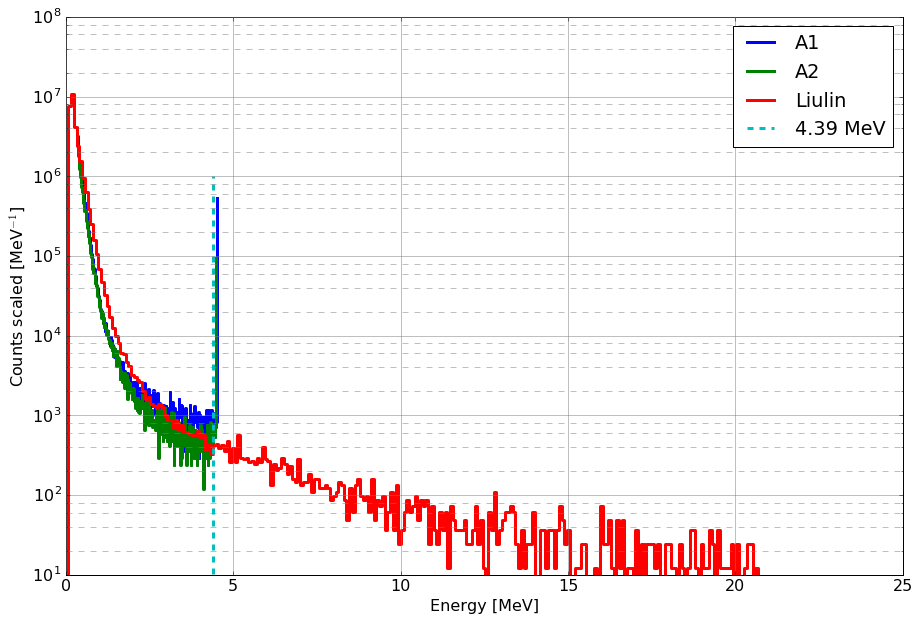

In [208]:
a1x=a1[a1[0]>263]
a2x=a2[a2[0]>265]
a1x.reset_index(inplace=True)
a1x['ch']=pd.to_numeric(a1x.index)
a2x.reset_index(inplace=True)
a2x['ch']=pd.to_numeric(a2x.index)

#ch. 239 is related to 4.39 MeV
a = 0.017 #channel width AIRDOS
b = 4.39 - a * 239

w = 0.0814 #0.0692 #0.0814 #channel width Liulin
#w = 0.0692 #0.0814 #channel width Liulin

a1x['e'] = a * a1x['ch'] + b
a2x['e'] = a * a2x['ch'] + b
liulin['e'] = (liulin[0]) * w - w/2

'''
plt.figure(figsize=(15,10))
matplotlib.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.plot(a1.loc[266:512,0]-261,a1.loc[266:512,1], label='A1')
plt.plot(a2.loc[266:512,0]-262,a2.loc[266:512,1], label='A2')
plt.plot(liulin[0]+1,liulin[1])
plt.legend()
'''

plt.figure(figsize=(15,10))
matplotlib.rcParams.update({'font.size': 16})
plt.yscale('log')
#plt.xlim(0, 10)
#plt.plot(a1x['e'],a1x[1]/0.017, label='A1', drawstyle='steps-mid')
#plt.plot(a2x['e'],a2x[1]/0.017, label='A2', drawstyle='steps-mid')
#plt.plot(liulin['e'],liulin[1]/0.069, label='Liulin', drawstyle='steps-mid')
plt.plot(a1x['e'],a1x[1]/a, lw=3, label='A1', drawstyle='steps-mid')
plt.plot(a2x['e'],a2x[1]/a, lw=3, label='A2', drawstyle='steps-mid')
plt.plot(liulin['e'],liulin[1]/w, lw=3, label='Liulin', drawstyle='steps-mid')

line = pd.DataFrame()
line['x']=[4.39,4.39]
line['y']=[0,1e6]
plt.plot(line['x'],line['y'],lw=3, linestyle='--', label='4.39 MeV')
plt.xlabel('Energy [MeV]')
plt.ylabel(r'Counts scaled [MeV$^{-1}$]')
plt.legend()
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='--')


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

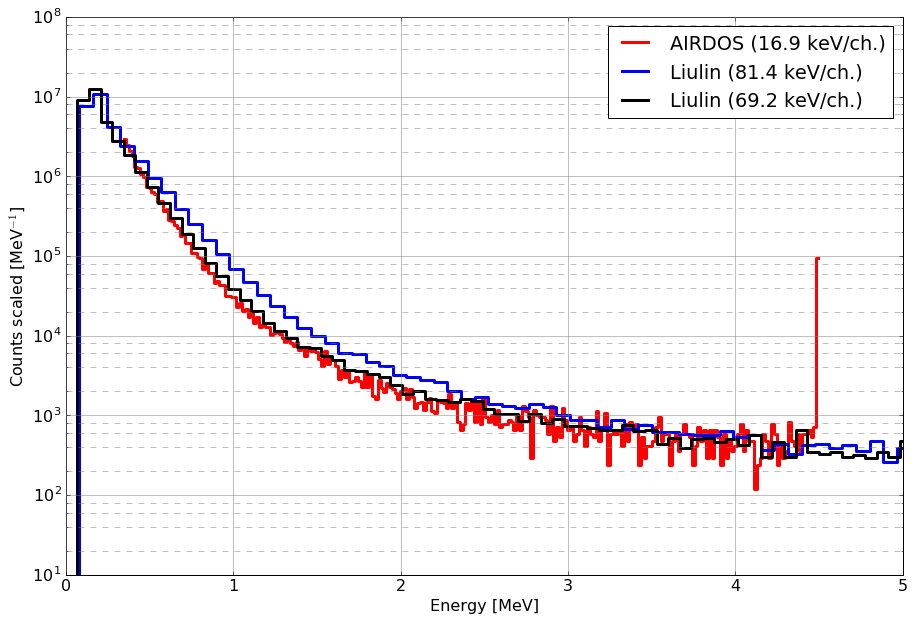

In [209]:
#a1x=a1[a1[0]>263]
#a2x=a2[a2[0]>265]
a1x.reset_index(inplace=True)
a1x['ch']=pd.to_numeric(a1x.index)
a2x.reset_index(inplace=True)
a2x['ch']=pd.to_numeric(a2x.index)

#ch. 239 is related to 4.39 MeV
a = 0.0169 #channel width AIRDOS
b = 4.39 - a * 239

w = 0.0814 

a1x['e'] = a * a1x['ch'] + b
a2x['e'] = a * a2x['ch'] + b
liulin['e'] = (liulin[0]) * w - w/2

plt.figure(figsize=(15,10))
matplotlib.rcParams.update({'font.size': 16})
plt.yscale('log')
#plt.xscale('log')
plt.xlim(0, 5)
plt.plot(a2x['e'],a2x[1]/a, c='r', lw=3, label='AIRDOS (16.9 keV/ch.)', drawstyle='steps-mid')
#plt.plot(liulin['e'],liulin[1]/w, c='black', linestyle=':', lw=3, label='Liulin (81.4 keV/ch.)', drawstyle='steps-mid')
plt.plot(liulin['e'],liulin[1]/w, c='blue', lw=3, label='Liulin (81.4 keV/ch.)', drawstyle='steps-mid')

w = 0.0814 
w = 0.0692
liulin['e'] = (liulin[0]) * w - w/2
plt.plot(liulin['e'],liulin[1]/w, c='black', lw=3, label='Liulin (69.2 keV/ch.)', drawstyle='steps-mid')


plt.xlabel('Energy [MeV]')
plt.ylabel(r'Counts scaled [MeV$^{-1}$]')
plt.legend()
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='--')

plt.savefig("musala.pdf", format="pdf", bbox_inches='tight')

In [852]:
from_energy = 0.35
to_energy = 4.5

a1x['dose']=a1x[1]*a1x['e']
a2x['dose']=a2x[1]*a1x['e']
liulin['dose']=liulin[1]*liulin['e']

a1_particles = a1x.loc[(a1x['e']>=from_energy)][1].sum()
a2_particles = a2x.loc[(a2x['e']>=from_energy)][1].sum()
liulin_particles = liulin.loc[(liulin['e']>=from_energy)][1].sum()

a1_dose = a1x.loc[(a1x['e']>=from_energy)&(a1x['e']<=to_energy)]['dose'].sum()
a2_dose = a2x.loc[(a2x['e']>=from_energy)&(a2x['e']<=to_energy)]['dose'].sum()
liulin_dose = liulin.loc[(liulin['e']>=from_energy)&(liulin['e']<=to_energy)]['dose'].sum()

a1norm = a1_dose/a1_particles
a2norm = a2_dose/a2_particles
liulinnorm = liulin_dose/liulin_particles

print 'Liulin','AIRDOS'
print liulin_particles, a1_particles, a2_particles
print liulin_particles/(a1_particles/100),'%', liulin_particles/(a2_particles/100),'%'
print liulin_dose, a1_dose, a2_dose
print liulin_dose/(a1_dose/100),'%', liulin_dose/(a2_dose/100),'%'
print liulinnorm, a1norm, a2norm
print liulinnorm/(a1norm/100),'%', liulinnorm/(a2norm/100),'%'
 

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Liulin AIRDOS
352951 462581 365417
76 % 96 %
186670.287 225700.6802 188565.8866
82.7070112658 % 98.9947282437 %
0.528884425883 0.487916019465 0.51602932157
108.396610233 % 102.491157726 %


In [696]:
a1x.to_csv('a1.csv')
a2x.to_csv('a2.csv')
liulin.to_csv('liulin.csv')


## Liulin Musala

In [211]:
df = pd.read_csv('./data/Musala/liulin.txt', header = None, sep = ',', skiprows = 1) # read Liulin data


(0, 300)

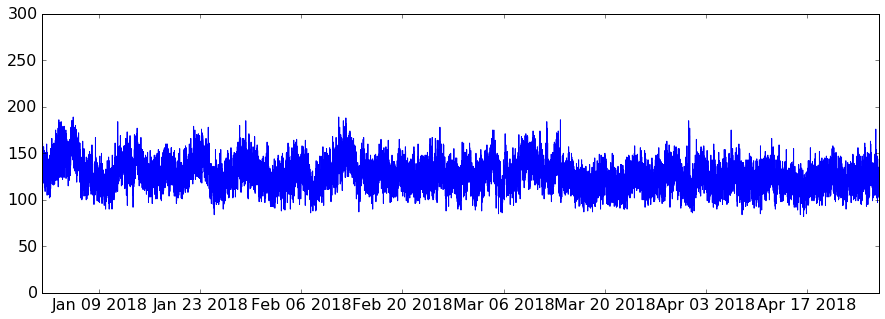

In [212]:
df['date'] = pd.to_datetime(df[0])
df = df.set_index(['date'])
df['flux'] = df[range(4,259)].sum(axis=1)

liulin = df.loc['2018-01-01 00:00:00':'2018-04-27 00:00:00']
#liulin = df.loc['2018-01-01 00:00:00':]
liulin = liulin.loc[(liulin['flux']<190)&(liulin['flux']>80)]

plt.figure(figsize=(15,5))
matplotlib.rcParams.update({'font.size': 16})

plt.plot(liulin['flux'])
plt.ylim(0, 300)


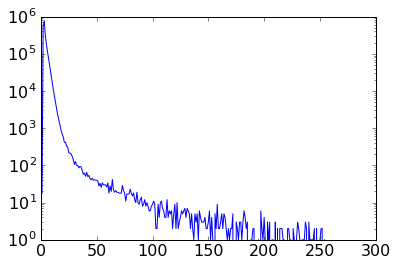

In [213]:
ener = liulin.ix[:,4:260].sum()

ener = ener.reset_index()
ener[1]=ener.index+1
ener = ener.set_index(1)

plt.plot(ener[0])
plt.yscale('log')

ener.to_csv('liulin.csv')

## AIRDOS Musala

In [214]:
# read AIRDOS data
df = pd.read_csv('./data/Musala/A2.txt', sep=',', header=None, comment='*', parse_dates=[0], error_bad_lines=False)


Skipping line 12360: expected 521 fields, saw 917

Skipping line 17177: expected 521 fields, saw 562

Skipping line 781443: expected 521 fields, saw 884



/usr/lib/python2.7/dist-packages/pandas/core/index.py:2864: FutureWarning:

In the future, 'NAT <= x' and 'x <= NAT' will always be False.



(0, 300)

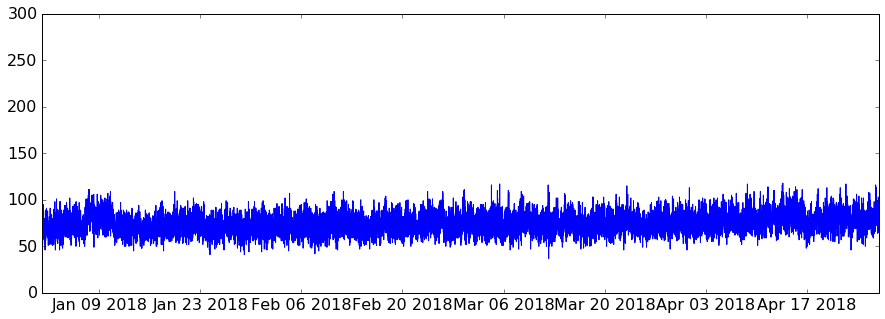

In [215]:
#df['date'] = pd.to_datetime(df[0])
df['date'] = pd.to_datetime(float64(df[0]),unit='s')
df = df.set_index(['date'])
df['flux'] = df[range(267,515)].sum(axis=1)

airdos = df.loc['2018-01-01 00:00:00':'2018-04-27 00:00:00']
airdos = airdos.loc[(airdos['flux']<12)]
airdos = airdos.resample('10 min', how='sum')
airdos = airdos.loc[(airdos['flux']<120)]

plt.figure(figsize=(15,5))

matplotlib.rcParams.update({'font.size': 16})

plt.plot(airdos['flux'])
plt.ylim(0, 300)


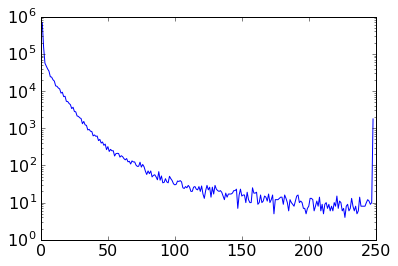

In [216]:
enera = airdos.ix[:,265:513].sum()

enera = enera.reset_index()
enera[1]=enera.index+1
enera = enera.set_index(1)

plt.plot(enera[0])
plt.yscale('log')

airdos.to_csv('A2_10min.csv')
enera.to_csv('A2.csv')

## Spectra Musala

In [217]:
#a1 = pd.read_table('A2.csv', sep=',', header=None, skiprows=1, engine='python' )
a2 = pd.read_table('A2.csv', sep=',', header=None,  skiprows=1, engine='python' )
liulin = pd.read_table('liulin.csv', sep=',', header=None,  skiprows=1, engine='python' )
#a1[0]=pd.to_numeric(a1.index)
#a1[1]=pd.to_numeric(a1[0])
a2[0]=pd.to_numeric(a2.index)
a2[1]=pd.to_numeric(a2[0])+256-247
liulin[1] = pd.to_numeric(liulin.index)+1


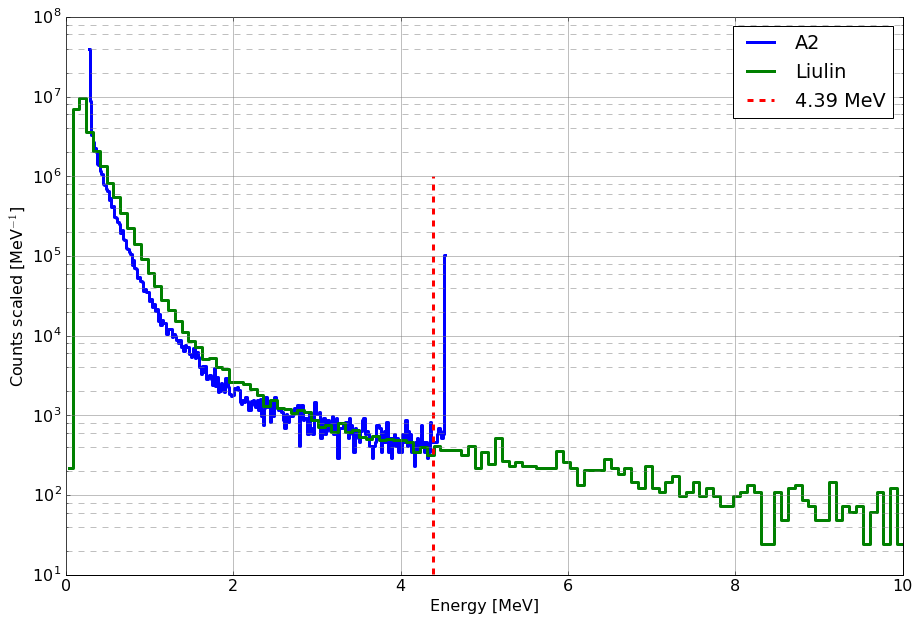

In [218]:
#a2x=a2[a2[0]>265]
a2x=a2
#a2x.reset_index(inplace=True)
a2x['ch']=pd.to_numeric(a2x[1])

#ch. 248 is related to 4.39 MeV
a = 0.0172 #channel width AIRDOS
b = 4.39 - a * 248

w = 0.0814 #0.0692 #0.0814 #channel width Liulin
#w = 0.0692 #0.0814 #channel width Liulin

a2x['e'] = a * a2x['ch'] + b
liulin['ch'] = liulin[1]
liulin['e'] = (liulin['ch']) * w - w/2

plt.figure(figsize=(15,10))
matplotlib.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.xlim(0, 10)
plt.plot(a2x['e'],a2x[2]/a, lw=3, label='A2', drawstyle='steps-mid')
plt.plot(liulin['e'],liulin[2]/w, lw=3, label='Liulin', drawstyle='steps-mid')

line = pd.DataFrame()
line['x']=[4.39,4.39]
line['y']=[0,1e6]
plt.plot(line['x'],line['y'],lw=3, linestyle='--', label='4.39 MeV')
plt.xlabel('Energy [MeV]')
plt.ylabel(r'Counts scaled [MeV$^{-1}$]')
plt.legend()
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='--')


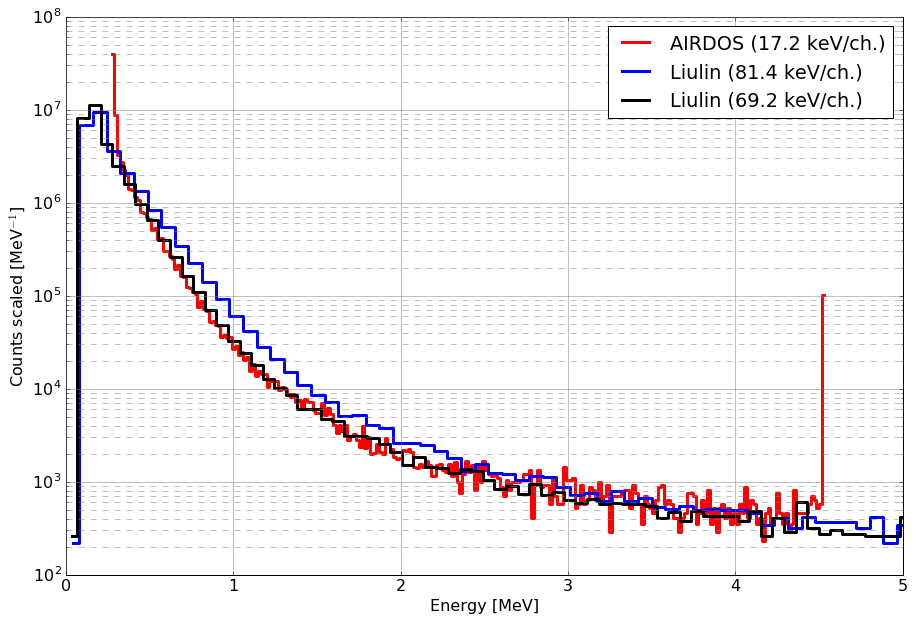

In [221]:
#ch. 248 is related to 4.39 MeV
a = 0.0172 #channel width AIRDOS
b = 4.39 - a * 248

w = 0.0814 

#a1x['e'] = a * a1x['ch'] + b
a2x['e'] = a * a2x['ch'] + b
liulin['e'] = (liulin[0]) * w - w/2

plt.figure(figsize=(15,10))
matplotlib.rcParams.update({'font.size': 16})
plt.yscale('log')
#plt.xscale('log')
plt.xlim(0, 5)
plt.ylim(100, 1e8)
plt.plot(a2x['e'],a2x[2]/a, c='r', lw=3, label='AIRDOS (17.2 keV/ch.)', drawstyle='steps-mid')
plt.plot(liulin['e'],liulin[2]/w, c='blue', lw=3, label='Liulin (81.4 keV/ch.)', drawstyle='steps-mid')

w = 0.0814 
w = 0.0692
liulin['e'] = (liulin[0]) * w - w/2
plt.plot(liulin['e'],liulin[2]/w, c='black', lw=3, label='Liulin (69.2 keV/ch.)', drawstyle='steps-mid')


plt.xlabel('Energy [MeV]')
plt.ylabel(r'Counts scaled [MeV$^{-1}$]')
plt.legend()
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='--')

plt.savefig("musala.pdf", format="pdf")

In [227]:
from_energy = 0.3
to_energy = 4.5

a2x['dose']=a2x[2]*a2x['e']
liulin['dose']=liulin[2]*liulin['e']

a2_particles = a2x.loc[(a2x['e']>=from_energy)][2].sum()
liulin_particles = liulin.loc[(liulin['e']>=from_energy)][2].sum()

a2_dose = a2x.loc[(a2x['e']>=from_energy)&(a2x['e']<=to_energy)]['dose'].sum()
liulin_dose = liulin.loc[(liulin['e']>=from_energy)&(liulin['e']<=to_energy)]['dose'].sum()

a2norm = a2_dose/a2_particles
liulinnorm = liulin_dose/liulin_particles

print 'Liulin','AIRDOS'
print 'couns', liulin_particles, a2_particles
print liulin_particles/(a2_particles/100),'%'
print 'dose', liulin_dose, a2_dose
print liulin_dose/(a2_dose/100),'%'
#print liulinnorm, a2norm
#print liulinnorm/(a2norm/100),'%'
 
#Value recorded by Liulin is~215987.2~MeV (in 478068~events), 14.2\% higher than the 189164.7~MeV (in 408882~events) recorded by AIRDOS.

Liulin AIRDOS
couns 478068 408882
116 %
dose 215987.1784 189164.7008
114.179430669 %


In [225]:
a2x

,0,1,2,ch,e,dose
0,0,9,687210,9,0.2792,191869.0320
1,1,10,149842,10,0.2964,44413.1688
2,2,11,55840,11,0.3136,17511.4240
3,3,12,46899,12,0.3308,15514.1892
4,4,13,39226,13,0.3480,13650.6480
5,5,14,34196,14,0.3652,12488.3792
6,6,15,24238,15,0.3824,9268.6112
7,7,16,23587,16,0.3996,9425.3652
8,8,17,20056,17,0.4168,8359.3408
9,9,18,18478,18,0.4340,8019.4520


## Energy calibration

In [61]:
fto = './data/DATALOG.TXT' #  File to Open
l=[]
l.extend(range(0,520))
df = pd.read_table(fto, sep=',', header=None, names=l, comment='*',engine='python' )

#
''' DEBUG
df = df.reset_index(drop=True)
df.drop(df[df.index > 100].index, inplace=True)
'''#'''

df.drop(df[df[0]=='$GPTXT'].index, inplace=True)
#df.drop(r[r[0]=='$GPRMC'].index, inplace=True)
df.drop(df[df[0]=='$GPVTG'].index, inplace=True)
df.drop(df[df[0]=='$GPGLL'].index, inplace=True)
df.drop(df[df[0]=='$GPGSA'].index, inplace=True)
df.drop(df[df[0]=='$GPGSV'].index, inplace=True)
#df.drop(df[df[0]=='$CANDY'].index, inplace=True)

# Convert strings to numbers
#df = df.apply(pd.to_numeric, errors='ignore')

#df.iloc[:,0:13]

#df

450


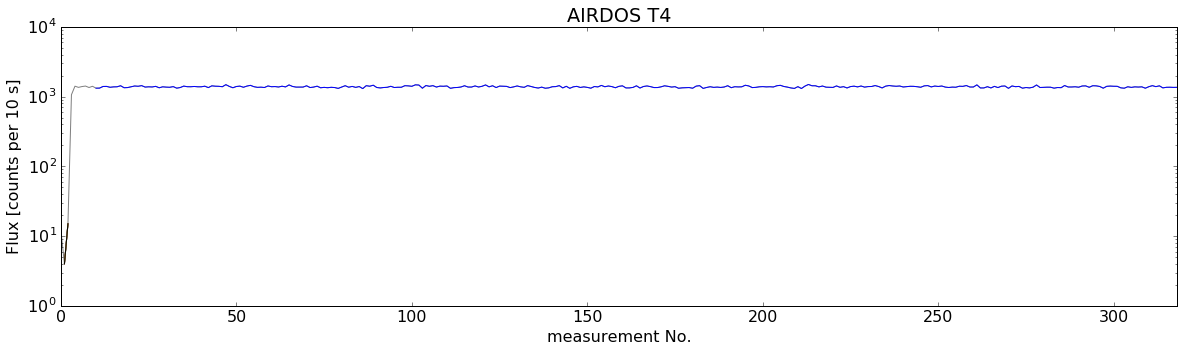

In [65]:
rc = df.loc[df[0]=='$CANDY2']
rc.reset_index(drop=True, inplace=True)

rc = rc.apply(pd.to_numeric, errors='coerce')

#rc.to_csv('ble.txt')

#rc['sum'] = rc[range(256,516)].sum(axis=1)
rc['sum'] = rc[range(265,513)].sum(axis=1)
#rc['sum']

plt.figure(figsize=(20,5))

#rc['sum'].plot()
rc.ix[0:,'sum'].plot(c='gray')
plt.yscale('log')

#plt.ylim([0,50])

# T4 ABSjests e1 = [700,1100]
e1 = [10,450]
e2 = [1,2]
e3 = [1,2]
e4 = [1,2]
e5 = [1,2]
e6 = [1,2]
e7 = [1,2]
e8 = [1,1]
'''T4 calibration
e1 = [1,20]
e2 = [60,190]
e3 = [220,1000]
e4 = [2900,2950]
e5 = [3035,3090]
e6 = [2400,2440]
e7 = [3100,3150]
e8 = [1,1]
#'''

rc.ix[e1[0]:e1[1],'sum'].plot()
rc.ix[e2[0]:e2[1],'sum'].plot()
rc.ix[e3[0]:e3[1],'sum'].plot()
rc.ix[e4[0]:e4[1],'sum'].plot()
rc.ix[e5[0]:e5[1],'sum'].plot()
rc.ix[e6[0]:e6[1],'sum'].plot()
rc.ix[e7[0]:e7[1],'sum'].plot()
rc.ix[e8[0]:e8[1],'sum'].plot()

plt.title('AIRDOS T4')
#plt.title('AIRDOS A005')
plt.xlabel('measurement No.')
plt.ylabel('Flux [counts per 10 s]')

print e1[1]

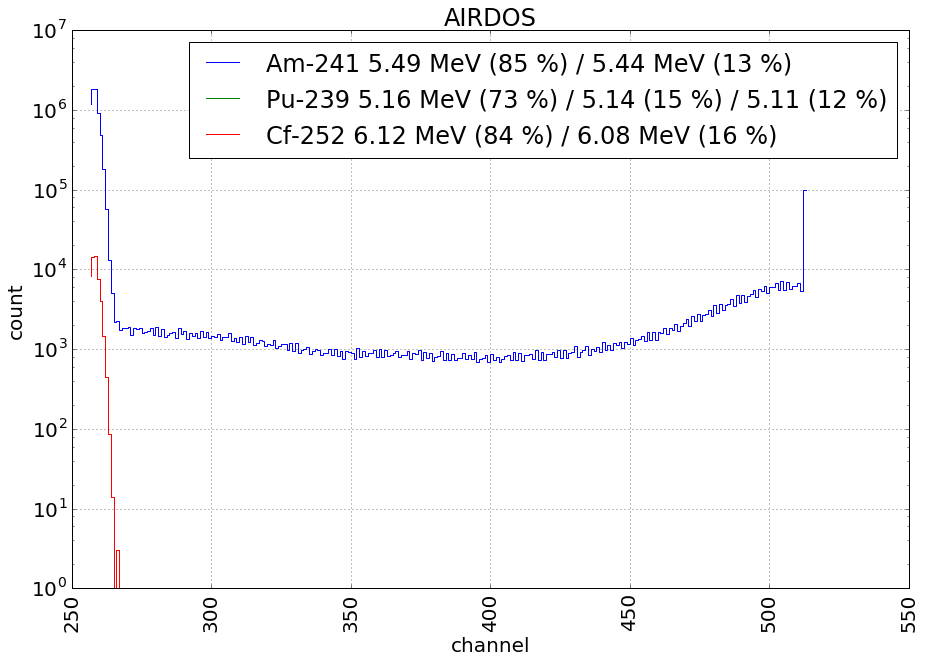

In [66]:
matplotlib.rcParams.update({'font.size': 20})

'''
plt.figure(figsize=(20,5))
rc['sum'][91:154].plot(c='blue')
rc['sum'][155:235].plot(c='red')
rc['sum'][236:296].plot(c='green')
rc['sum'][300:350].plot(c='yellow')
'''

LOW_ENERGY = 257

ener1 = rc.ix[e1[0]:e1[1],LOW_ENERGY:514].sum()
ener2 = rc.ix[e2[0]:e2[1],LOW_ENERGY:514].sum()
ener3 = rc.ix[e3[0]:e3[1],LOW_ENERGY:514].sum()
ener4 = rc.ix[e4[0]:e4[1],LOW_ENERGY:514].sum()
ener5 = rc.ix[e5[0]:e5[1],LOW_ENERGY:514].sum()
ener6 = rc.ix[e6[0]:e6[1],LOW_ENERGY:514].sum()
ener7 = rc.ix[e7[0]:e7[1],LOW_ENERGY:514].sum()
ener8 = rc.ix[e8[0]:e8[1],LOW_ENERGY:514].sum()
 
plt.figure(figsize=(15,10))
plt.yscale('log')


#plt.plot(ener3, label='9 V Glass', drawstyle='steps-pre')
#plt.plot(ener2, label='GVA-PRG', drawstyle='steps-pre')
#plt.plot(enr1, label='p+', drawstyle='steps-pre')
plt.plot(ener1, label='Am-241 5.49 MeV (85 %) / 5.44 MeV (13 %)', drawstyle='steps-pre')
plt.plot(ener2, label='Pu-239 5.16 MeV (73 %) / 5.14 (15 %) / 5.11 (12 %)', drawstyle='steps-pre')
plt.plot(ener3, label='Cf-252 6.12 MeV (84 %) / 6.08 MeV (16 %)', drawstyle='steps-pre')
#plt.plot(ener1, label='e1',  drawstyle='steps-pre')
#plt.plot(ener2, label='e2',  drawstyle='steps-pre')
#plt.plot(ener3, label='e3',  drawstyle='steps-pre')
#plt.plot(ener4, label='e4',  drawstyle='steps-pre')
#plt.plot(ener5, label='e5',  drawstyle='steps-pre')
#plt.plot(ener6, label='e6',  drawstyle='steps-pre')
#plt.plot(ener7, label='e7',  drawstyle='steps-pre')
#plt.plot(ener8, label='e8',  drawstyle='steps-pre')
#plt.plot(ener3*100, label='e3*100',  drawstyle='steps-pre')
#plt.plot(ener4*1000, label='e4*1000',  drawstyle='steps-pre')
#plt.plot(ener5*10000, label='e5*10000',  drawstyle='steps-pre')
#plt.plot(ener5, label='Am-241 5.49 MeV colim.',  drawstyle='steps-pre')
#plt.ylim([0,5000])
#plt.xlim([250,300])
plt.legend()
plt.title('AIRDOS')
#plt.title('AIRDOS T4 Alpha Spectrum')
plt.xlabel('channel')
plt.ylabel('count')
#plt.xticks(range(500,1030,10))
plt.xticks(rotation=90)
plt.grid()


In [71]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

data = [
    go.Scatter(
        x=ener1.index,
        y=ener1,
        name='p+ deg. 0',
        yaxis='y',
        line=dict(
        shape='hvh'
        )
    ),    
    go.Scatter(
        x=ener1.index,
        y=ener4,
        name='p+ deg. 3',
        yaxis='y',
        line=dict(
        shape='hvh'
        )
    ),    
    go.Scatter(
        x=ener1.index,
        y=ener3,
        name='p+ deg. 4',
        yaxis='y',
        line=dict(
        shape='hvh'
        )
    ),    
    go.Scatter(
        x=ener1.index,
        y=ener2,
        name='p+ deg. 2,4',
        yaxis='y',
        line=dict(
        shape='hvh'
        )
    ),    
    go.Scatter(
        x=ener1.index,
        y=ener7,
        name='Pu 5.16 MeV',
        yaxis='y',
        line=dict(
        shape='hvh'
        )
    ),    
    go.Scatter(
        x=ener1.index,
        y=ener5,
        name='Am 5.49 MeV',
        yaxis='y',
        line=dict(
        shape='hvh'
        )
    ),
    go.Scatter(
        x=ener1.index,
        y=ener6,
        name='Cf 6.12 MeV',
        yaxis='y',
        line=dict(
        shape='hvh'
        )
    ),
    go.Scatter(
        x=ener1.index,
        y=ener8,
        name='Am 1 cm',
        yaxis='y',
        line=dict(
        shape='hvh'
        )
    ),
    ]

layout = go.Layout(
    title='AIRDOS',
    font=dict(family='Courier New, monospace', size=18, color='#7f7f7f'),
    yaxis=dict(
        title='counts',
        #type='log',
        range = [0,10000]

    ),
    xaxis=dict(
        title='Ch. [-]',
    )
)

fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig, filename='ble')


In [72]:
ener1

257    1190272
258    1826536
259    1834259
260     923680
261     487416
262     181146
263      58124
264      13204
265       5052
266       2208
267       2287
268       1728
269       1863
270       1835
271       1920
272       1504
273       1821
274       1767
275       1826
276       1601
277       1631
278       1666
279       1844
280       1496
281       1891
282       1445
283       1809
284       1419
285       1527
286       1583
        ...   
484       3056
485       3577
486       3674
487       4253
488       3495
489       4777
490       3815
491       4765
492       3955
493       4645
494       4862
495       5587
496       4509
497       5678
498       5368
499       6186
500       5120
501       5992
502       5977
503       6720
504       5505
505       7133
506       5552
507       6943
508       5614
509       6151
510       6240
511       6668
512       5370
513      98779
dtype: float64